In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge, LogisticRegression
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import scale, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

%matplotlib inline
plt.style.use('ggplot')
import warnings
warnings.filterwarnings(action="ignore")

from sklearn.pipeline import Pipeline

In [80]:
#!gdown 1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K  # train.csv
#!gdown 1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r  # test.csv
#!gdown 199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y  # submission.csv

In [81]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv');

In [82]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

Посмотрим на пропущенные значения или пробелы в данных:

In [83]:
print("null_data", pd.concat([train[feature_cols] , test ]).isnull().sum().sum())
print("null_target", train[target_col].isnull().mean())

# Для работы с данными
# Будем здесь хранить 'хорошие' данные
train_good = train[feature_cols]
test_good = test.copy()
pred_good = train[target_col]

# Кол-во " " в каждом столбце  
for col in feature_cols:
    n = list(pd.concat([train[feature_cols] , test])[col]).count(' ')
    if (n > 0):
        print(col, n)

# Заменим пробел на 0 для признака TotalSpent
train_good['TotalSpent'] = (train['TotalSpent'].replace(' ', 0)).astype('float')
test_good['TotalSpent'] = (test['TotalSpent'].replace(' ', 0)).astype('float')

null_data 0
null_target 0.0
TotalSpent 11


In [84]:
agg_func_math = {
    'TotalSpent': ['mean', 'median', 'min', 'max'], 
    'MonthlySpending': ['min', 'max', 'median', 'mean'],
    'ClientPeriod': ['min', 'max', 'median', 'mean']
}
test_good.join(pred_good).groupby(['Churn']).agg(agg_func_math).round(2)
train_good.join(pred_good).groupby(['Churn']).agg(agg_func_math).round(2)

TotalSpent                         MonthlySpending                 \
            mean   median   min      max             min     max median   
Churn                                                                     
0        2557.91  1709.12   0.0  8672.45           18.25  118.75  64.78   
1        1525.83   706.72  19.1  8684.80           18.95  118.35  79.50   

             ClientPeriod                    
        mean          min max median   mean  
Churn                                        
0      61.60            0  72   37.0  37.53  
1      74.28            1  72   10.0  17.95

In [85]:
import collections
collections.Counter(list(pred_good)), np.mean(pred_good)
#Как мы видим есть дисбаланс классов, будем учитывать это при обучении

(Counter({0: 3898, 1: 1384}), 0.26202196137826583)

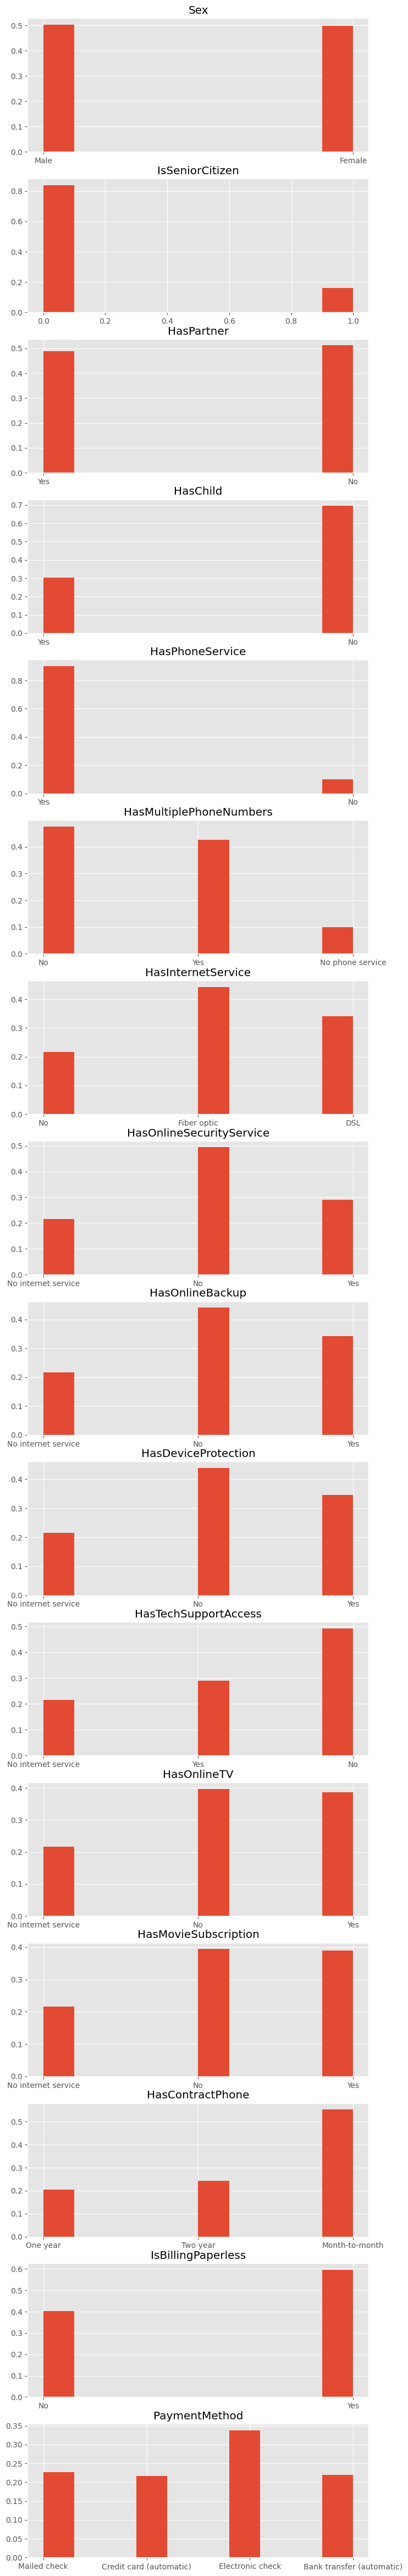

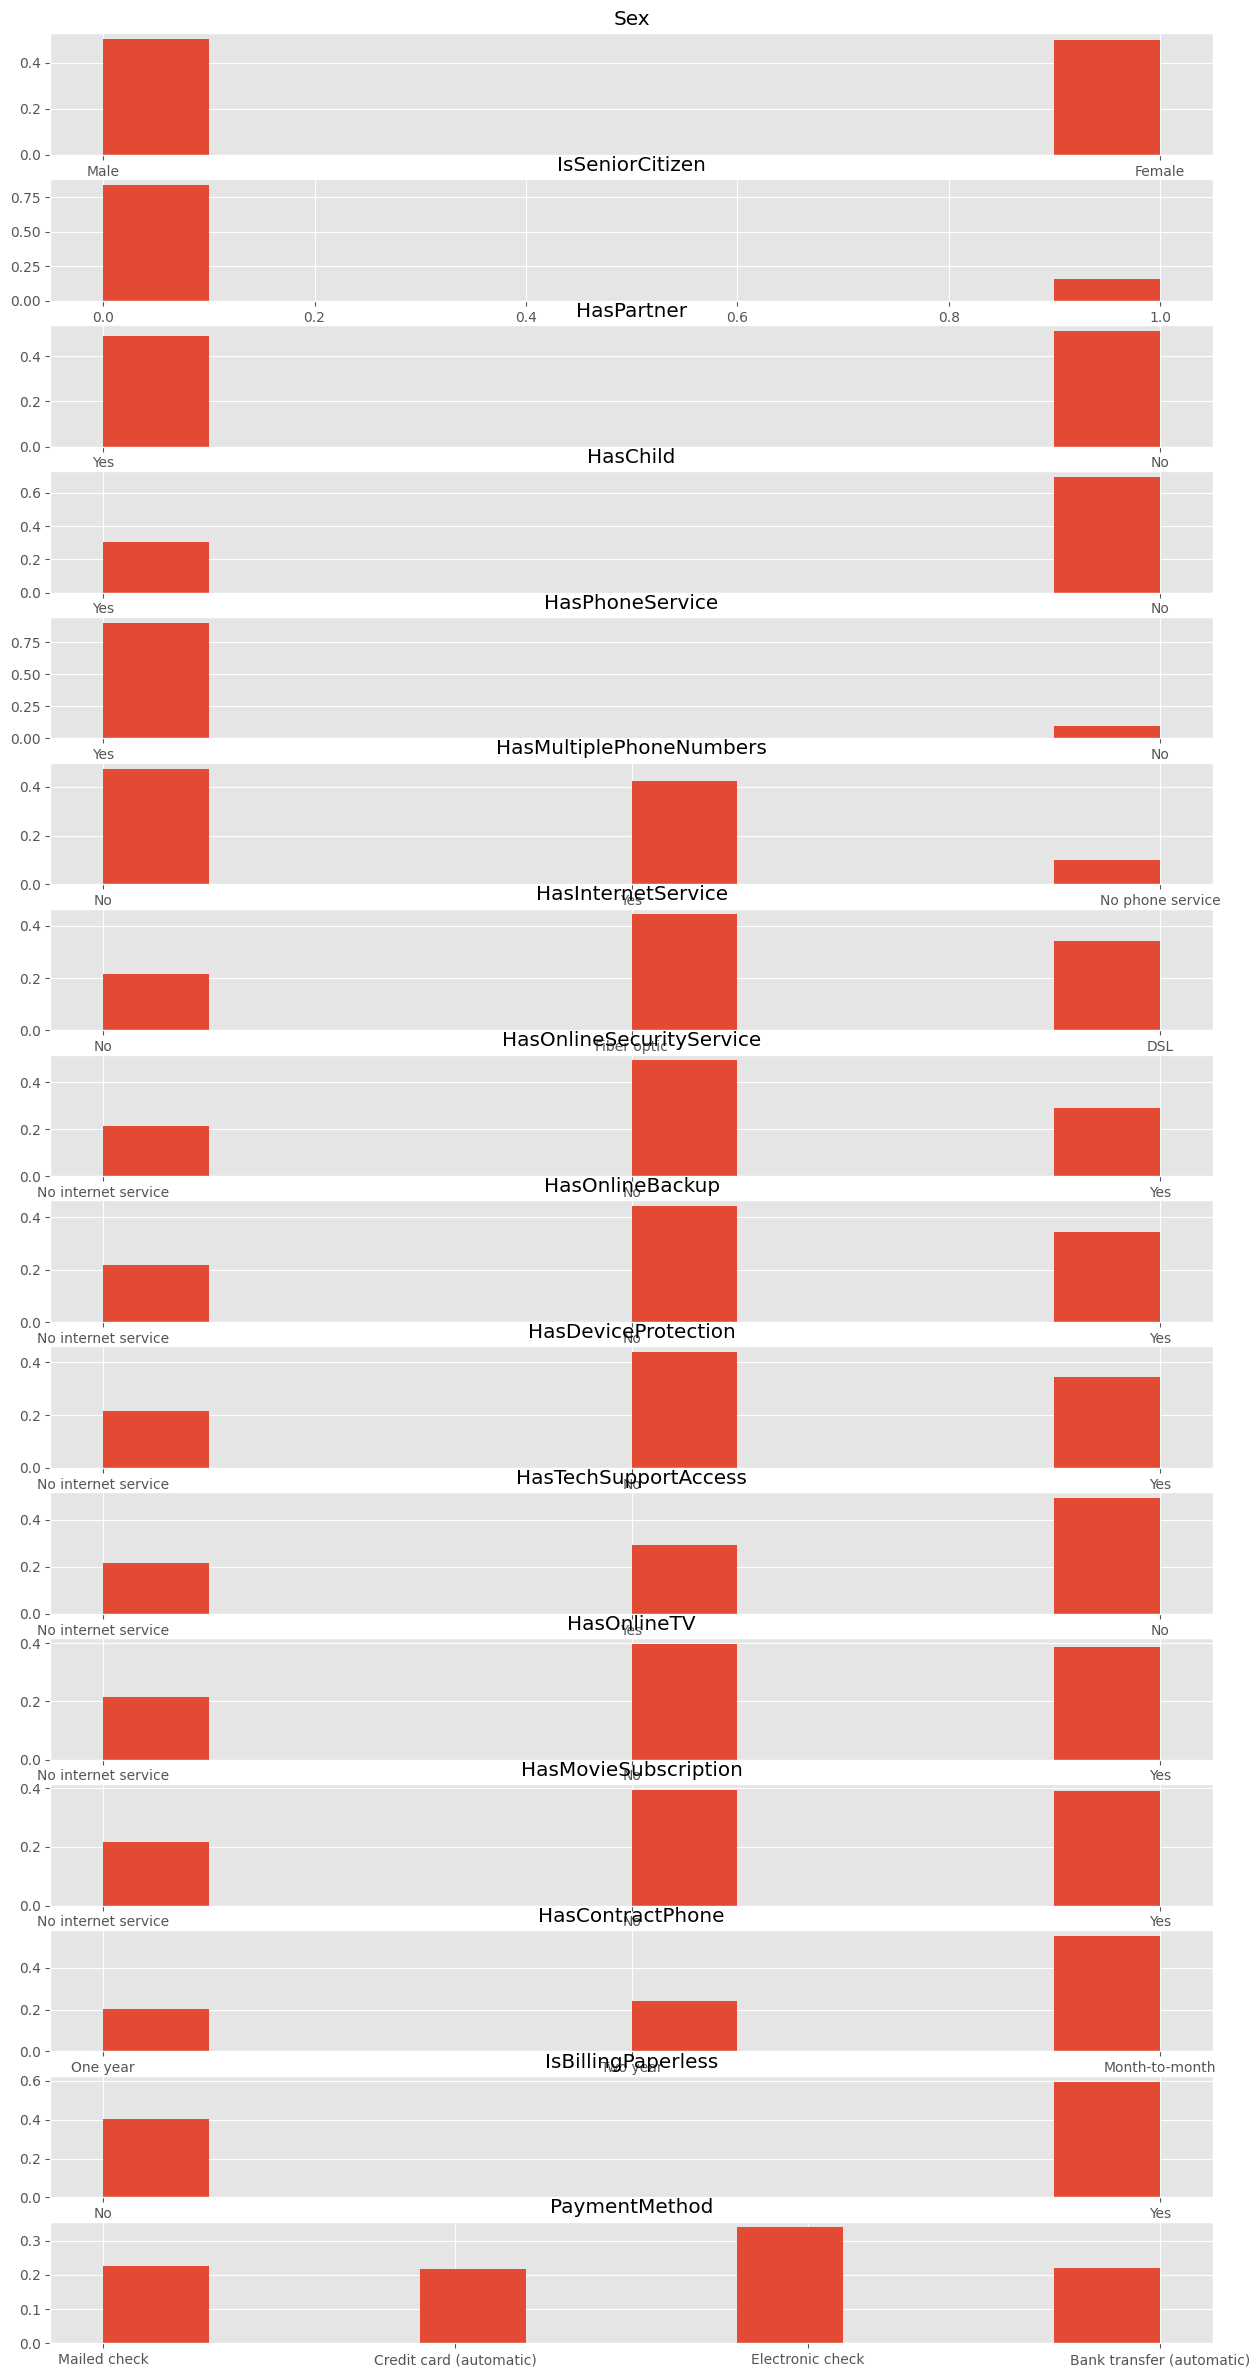

In [86]:
fig, axs = plt.subplots(16, figsize=(8, 60))
for i in range(0,16):
    axs[i].set_title(cat_cols[i])
    axs[i].hist(train_good[cat_cols[i]], weights=np.ones_like(train_good[cat_cols[i]]) / len (train_good[cat_cols[i]]))

fig, axs = plt.subplots(16, figsize=(15, 30))
for i in range(0,16):
    axs[i].set_title(cat_cols[i])
    axs[i].hist(train_good[cat_cols[i]], weights=np.ones_like(train_good[cat_cols[i]]) / len (train_good[cat_cols[i]]))

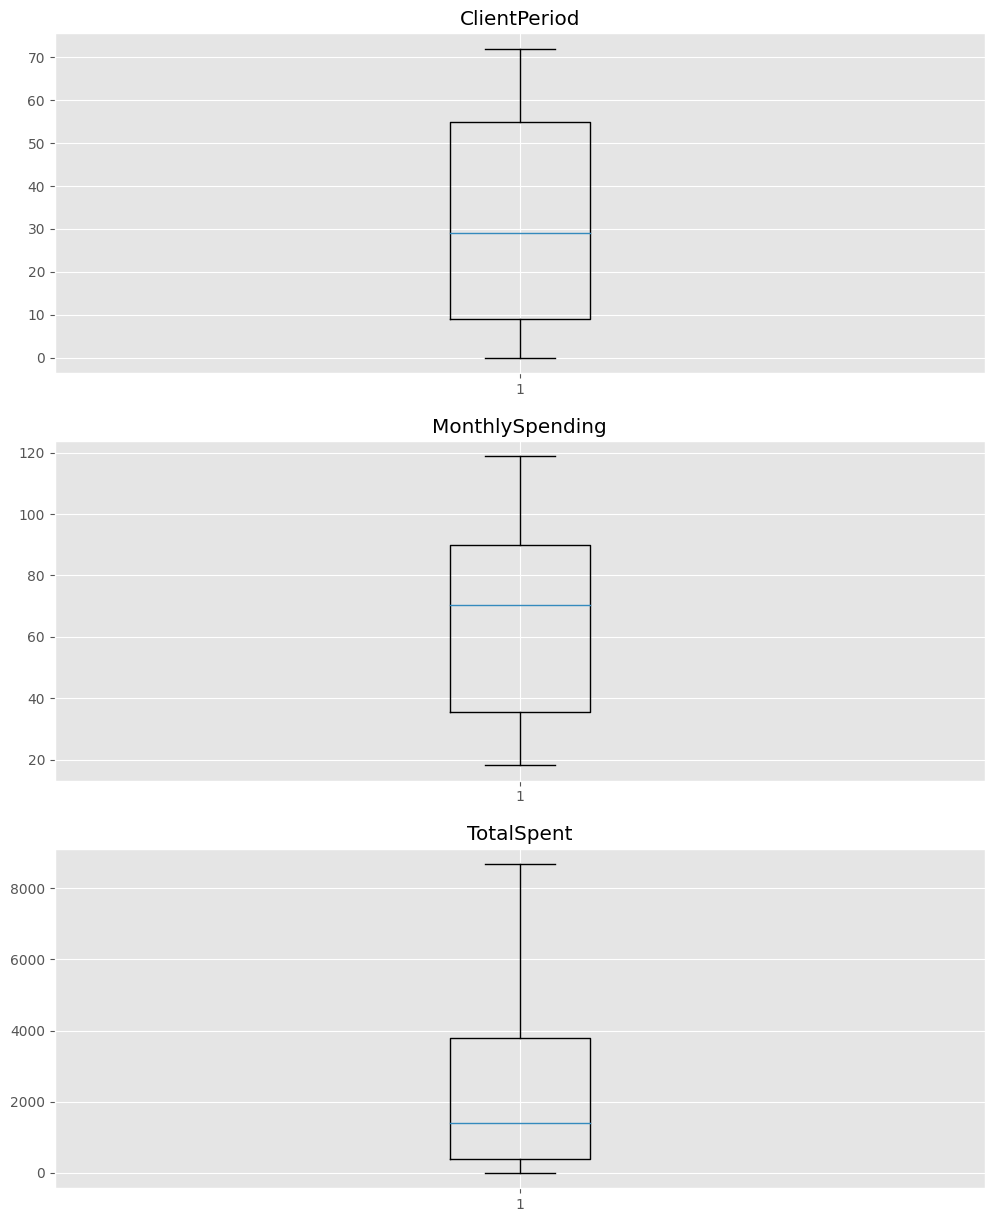

In [87]:
fig, axs = plt.subplots(3, figsize=(12, 15))
for i in range(3):
    axs[i].set_title(num_cols[i])
    axs[i].boxplot(train_good[num_cols[i]])

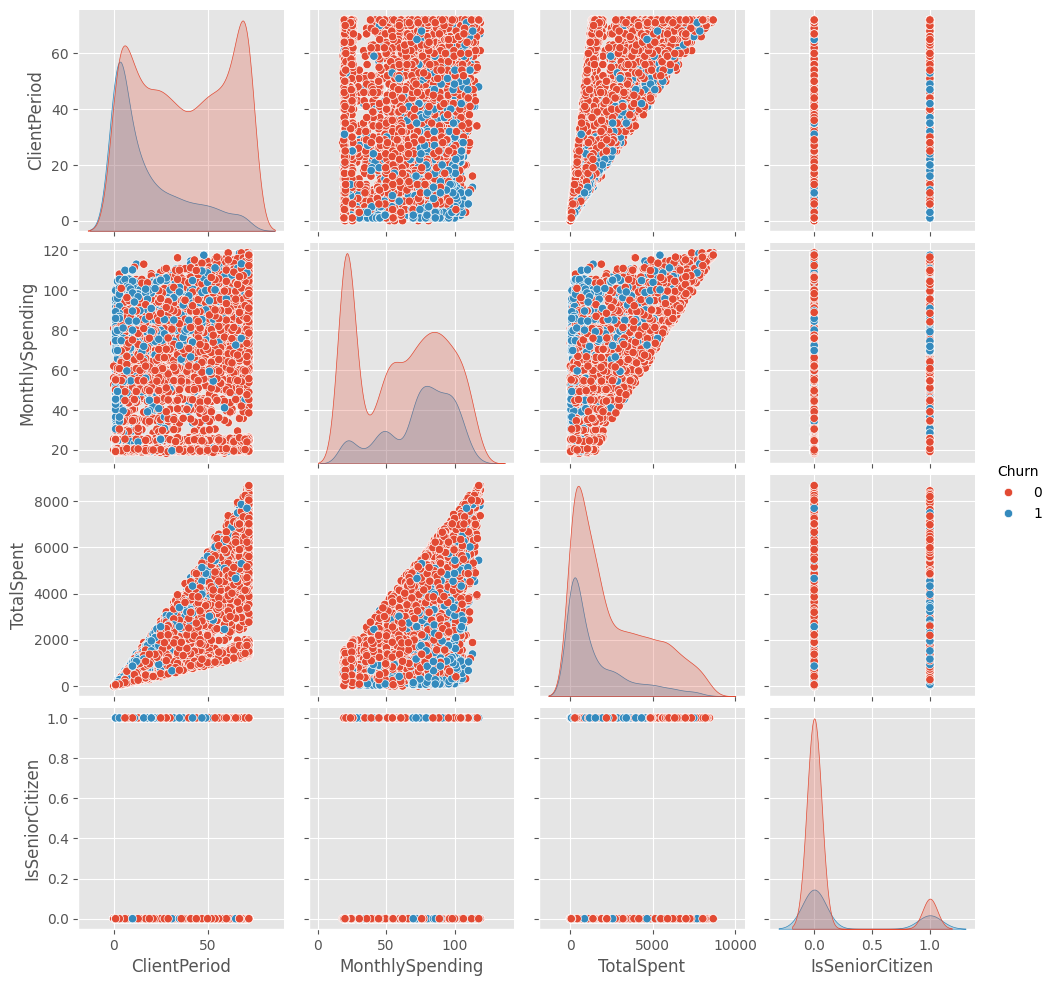

In [88]:
sns.pairplot(train_good.join(pred_good), hue='Churn')

Построим матрицу корреляции 

In [89]:
train_good[num_cols].corr()

#  Удаляем TotalSPent

,ClientPeriod,MonthlySpending,TotalSpent
ClientPeriod,1.000000,0.249414,0.826658
MonthlySpending,0.249414,1.000000,0.652014
TotalSpent,0.826658,0.652014,1.000000


## 2) Линейные модели

### LogisticRegression

In [90]:
X = train_good.drop(['TotalSpent'], axis=1)
num_cols = num_cols[:2]
y = pred_good

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [92]:
preprocessing = ColumnTransformer(
    [("num", StandardScaler(), num_cols), ("cat", OneHotEncoder(), cat_cols)]
)

pipe_log = Pipeline(
    [
        ("preprocess", preprocessing),
        ("model", LogisticRegression(random_state=10))
    ]
)

In [93]:
param_grid = {
    "model__solver": ['lbfgs', 'liblinear', 'saga'],
    "model__penalty": ['l1', 'l2'],
    "model__C": np.linspace(0.001, 200, 50)
}
skf = StratifiedKFold(n_splits=5, shuffle=True)

In [94]:
grid = GridSearchCV(
    pipe_log, param_grid=param_grid, scoring="roc_auc", cv=skf, verbose=0
)
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['ClientPeriod',
                                                                          'MonthlySpending']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['Sex',
                                                                          'IsSeniorCitizen',
                                                                          'HasPartner',
                                                                          'HasChild',
                                                                          'HasPhoneService',
                                                                          'HasMultiplePhoneNumbers',
                                                                          'HasInternetService',
                                                                          'HasOn...
       1.30612592e+02, 1.34694204e+02, 1.38775816e+02, 1.42857429e+02,
       1.46939041e+02, 1.51020653e+02, 1.55102265e+02, 1.59183878e+02,
       1.63265490e+02, 1.67347102e+02, 1.71428714e+02, 1.75510327e+02,
       1.79591939e+02, 1.83673551e+02, 1.87755163e+02, 1.91836776e+02,
       1.95918388e+02, 2.00000000e+02]),
                         'model__penalty': ['l1', 'l2'],
                         'model__solver': ['lbfgs', 'liblinear', 'saga']},
             scoring='roc_auc')

In [95]:
grid.best_params_, grid.best_score_

({'model__C': 12.245836734693878,
  'model__penalty': 'l1',
  'model__solver': 'liblinear'},
 0.8443077756032638)

In [96]:
## Избавляемся от '__' в ключах словаря с лучшими параметрами
def best_params(param_dict):
    return dict(map(lambda x, y: (x.split('__')[-1], y), list(param_dict.keys()), list(param_dict.values())))
best_params(grid.best_params_)

{'C': 12.245836734693878, 'penalty': 'l1', 'solver': 'liblinear'}

Построим ROC-кривую для X_train и X_test

In [97]:
pipe_log_roc = Pipeline(
    [
        ("preprocess", preprocessing),
        ("model", LogisticRegression(random_state=10, **best_params(grid.best_params_)))
    ]
)

pipe_log_roc.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['ClientPeriod',
                                                   'MonthlySpending']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Sex', 'IsSeniorCitizen',
                                                   'HasPartner', 'HasChild',
                                                   'HasPhoneService',
                                                   'HasMultiplePhoneNumbers',
                                                   'HasInternetService',
                                                   'HasOnlineSecurityService',
                                                   'HasOnlineBackup',
                                                   'HasDeviceProtection',
                                                   'HasTechSupportAccess',
                                                   'HasOnlineTV',
                                                   'HasMovieSubscription',
                                                   'HasContractPhone',
                                                   'IsBillingPaperless',
                                                   'PaymentMethod'])])),
                ('model',
                 LogisticRegression(C=12.245836734693878, penalty='l1',
                                    random_state=10, solver='liblinear'))])

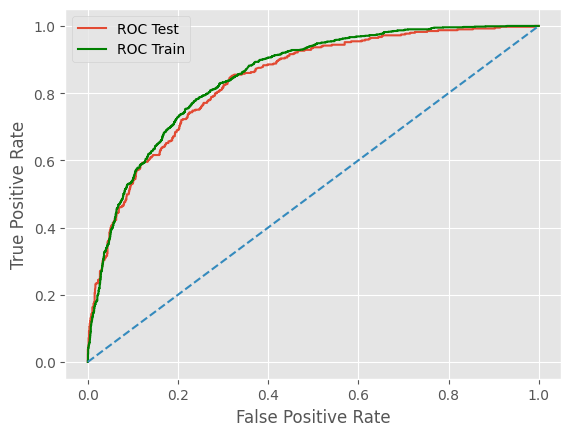

In [98]:
fpr_test, tpr_test, treshold = roc_curve(y_test, pipe_log_roc.predict_proba(X_test)[:, 1])
fpr_train, tpr_train, treshold = roc_curve(y_train, pipe_log_roc.predict_proba(X_train)[:, 1])
plt.plot(fpr_test, tpr_test, label='ROC Test')
plt.plot(fpr_train, tpr_train, label='ROC Train', c='g')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [99]:
print("score:", roc_auc_score(y_test, pipe_log_roc.predict_proba(X_test)[:, 1]))

score: 0.8383209949280188


### CatBoost

In [100]:
cb = CatBoostClassifier(
    cat_features=cat_cols,
    eval_metric="AUC:hints=skip_train~false",
    metric_period=1000,
)
grid_params = {
    "n_estimators": np.arange(30, 240, 50),
    "learning_rate": np.linspace(0.1, 0.3, 4),
    "max_depth": np.arange(1, 4, 1),
    "l2_leaf_reg": [0.1, 0.8]
}

skf = StratifiedKFold(n_splits=6)

In [101]:
X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(X, y, test_size=0.3)

In [102]:
cb.grid_search(grid_params, X_train_cb, y_train_cb, cv=skf, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6594533	test: 0.6487226	best: 0.6487226 (0)	total: 2.87ms	remaining: 83.1ms
29:	learn: 0.8254634	test: 0.8363794	best: 0.8363794 (29)	total: 147ms	remaining: 0us

bestTest = 0.836379448
bestIteration = 29

0:	loss: 0.8363794	best: 0.8363794 (0)	total: 173ms	remaining: 20.6s
0:	learn: 0.6594533	test: 0.6487226	best: 0.6487226 (0)	total: 2.03ms	remaining: 58.9ms
29:	learn: 0.8352726	test: 0.8462971	best: 0.8462971 (29)	total: 141ms	remaining: 0us

bestTest = 0.8462971411
bestIteration = 29

1:	loss: 0.8462971	best: 0.8462971 (1)	total: 315ms	remaining: 18.6s
0:	learn: 0.6594533	test: 0.6487226	best: 0.6487226 (0)	total: 2.06ms	remaining: 59.8ms
29:	learn: 0.8378918	test: 0.8479414	best: 0.8479414 (29)	total: 150ms	remaining: 0us

bestTest = 0.8479413777
bestIteration = 29

2:	loss: 0.8479414	best: 0.8479414 (2)	total: 467ms	remaining: 18.2s
0:	learn: 0.6594533	test: 0.6487226	best: 0.6487226 (0)	total: 2.63ms	remaining: 76.3ms
29:	learn: 0.8378170	test: 0.8455891	best: 0.8455

{'params': {'depth': 2,
  'iterations': 230,
  'learning_rate': 0.16666666666666669,
  'l2_leaf_reg': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0, 229],
              'test-AUC-mean': [0.7040763318219402, 0.8408231322248335],
              'test-AUC-std': [0.027978134269700146, 0.023077034397678293],
              'train-AUC-mean': [0.7150779224030884, 0.8689772593540841],
              'train-AUC-std': [0.02006399907783587, 0.0050542822687418675],
              'test-Logloss-mean': [0.6247946492789982, 0.41530183032978724],
              'test-Logloss-std': [0.004324353276344361, 0.02422560342108053],
              'train-Logloss-mean': [0.6242218195279142, 0.38279999736341086],
              'train-Logloss-std': [0.002844522839766635,
               0.0061890546496725755]})}

In [103]:
best_p = {'iterations': cb.get_params().get('iterations'),
          'depth': cb.get_params().get('depth'),
          'learning_rate': cb.get_params().get('learning_rate'),
          'l2_leaf_reg': cb.get_params().get('l2_leaf_reg')
}
best_p, cb.best_score_

({'iterations': 230,
  'depth': 2,
  'learning_rate': 0.16666666666666669,
  'l2_leaf_reg': 0.1},
 {'learn': {'Logloss': 0.38402242867712005, 'AUC': 0.8674627599935931}})

In [104]:
cb_roc = CatBoostClassifier(
    cat_features=cat_cols,
    eval_metric="AUC:hints=skip_train~false",
    metric_period=1000,
    **best_p
)

In [105]:
cb_roc.fit(X_train_cb, y_train_cb)

0:	learn: 0.7325390	total: 5.8ms	remaining: 1.33s
229:	learn: 0.8674628	total: 1.53s	remaining: 0us


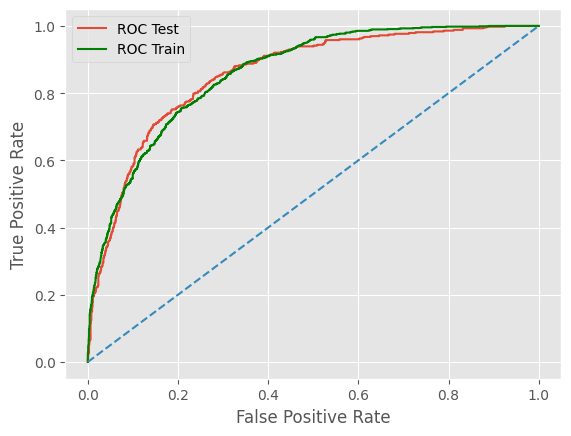

In [106]:
fpr_test, tpr_test, treshold = roc_curve(y_test_cb, cb_roc.predict_proba(X_test_cb)[:, 1])
fpr_train, tpr_train, treshold = roc_curve(y_train_cb, cb_roc.predict_proba(X_train_cb)[:, 1])
plt.plot(fpr_test, tpr_test, label='ROC Test')
plt.plot(fpr_train, tpr_train, label='ROC Train', c='g')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [107]:
print("score:", roc_auc_score(y_test_cb, cb_roc.predict_proba(X_test_cb)[:, 1]))

score: 0.857919452500273


## 3) Обучение результирующей модели 

In [108]:
preprocessing = ColumnTransformer(
    [("num", StandardScaler(), num_cols), ("cat", OneHotEncoder(), cat_cols)]
)

pipe_gb = Pipeline(
    [
        ("preprocess", preprocessing),
        ("model", LogisticRegression(random_state=10))
    ]
)

skf = StratifiedKFold(n_splits=6, shuffle=True)

In [109]:
param_grid = {
    "model__solver": ['lbfgs', 'liblinear', 'saga'],
    "model__penalty": ['l1', 'l2'],
    "model__C": np.linspace(0.001, 200, 50)
}

In [110]:
gr_gb = GridSearchCV(pipe_gb, param_grid=param_grid, verbose=0, scoring='roc_auc', cv=skf)

In [111]:
gr_gb.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['ClientPeriod',
                                                                          'MonthlySpending']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['Sex',
                                                                          'IsSeniorCitizen',
                                                                          'HasPartner',
                                                                          'HasChild',
                                                                          'HasPhoneService',
                                                                          'HasMultiplePhoneNumbers',
                                                                          'HasInternetService',
                                                                          'HasOn...
       1.30612592e+02, 1.34694204e+02, 1.38775816e+02, 1.42857429e+02,
       1.46939041e+02, 1.51020653e+02, 1.55102265e+02, 1.59183878e+02,
       1.63265490e+02, 1.67347102e+02, 1.71428714e+02, 1.75510327e+02,
       1.79591939e+02, 1.83673551e+02, 1.87755163e+02, 1.91836776e+02,
       1.95918388e+02, 2.00000000e+02]),
                         'model__penalty': ['l1', 'l2'],
                         'model__solver': ['lbfgs', 'liblinear', 'saga']},
             scoring='roc_auc')

In [112]:
gr_gb.best_params_, gr_gb.best_score_

({'model__C': 16.32744897959184,
  'model__penalty': 'l1',
  'model__solver': 'liblinear'},
 0.8445479694765085)

In [113]:
preprocessing = ColumnTransformer(
    [("num", StandardScaler(), num_cols), ("cat", OneHotEncoder(), cat_cols)]
)

pipe_log_result = Pipeline(
    [
        ("preprocess", preprocessing),
        ("model", LogisticRegression(random_state=10, **best_params(grid.best_params_)))
    ]
)

In [114]:
best_model = pipe_log_result.fit(X, y)

In [115]:
pred = best_model.predict_proba(test_good.drop(['TotalSpent'], axis=1))

In [116]:
submission = {
    'Id': np.arange(0, len(pred[:, 1])), 
    'Churn': pred[:, 1]
}
solution1 = pd.DataFrame(submission)
solution1['Id'] = solution1['Id'].astype('int')
solution1.to_csv('submission_churn.csv',index=False)